# Results - Round I

* J. Emmanuel Johnson
* 11th Nov, 2019

## Recap

Recall that we are looking at different IT measures and how they compare when we look at drought years (2012, 2014, 2015) and non-drought years (2010, 2011, 2013). We vary the amount of temporal features that we are adding; i.e. we increase the number of previous time steps available for our samples. We can divide the IT measures we use into two groups:

* Individual Measures - where we measure each variable independenly.
    * Entropy - expected (average) amount of uncertainty
    * Total Correlation - amount of redundant information within the features
* Comparative Measures - where we compare multiple variables to one another
    * Mutual Information - amount of shared information between two multivariate datasets.
    * Pearsons Correlation Coefficient - the amount of correlation that can be found between two datasets.
    
The hypothesis would be:

1. Individual Measures - we see some trend that perhaps gives us intuition that there could be a 'sweet' spot for the amount of temporal dimensions to use.
2. Comparative Measures - the IT measures would exhibit a similar trend we saw for the individual measures but there should depend on the two variables we are comparing. For example the MI between SM and VOD should be higher than between SM and VOD.
3. Comparative Measures - the pearson correlation measures won't be so helpful in this case because it is a linear method that shouldn't do a good job at capturing the nonlinear variability/interactions that we expect.

## Concerns

1. **Calculating the Pearson coefficient**

The pearson coeff isn't a multivariate measure (I don't think). So to do it for multi-dimensional data, I simply 'unraveled' the array such that I compared sample-to-sample and feature-to-feature. But I'm not sure if this is correct.

2. **Climatology**

I removed the climatology but I would like to see what happens when I don't remove the climatology. I don't think the results are much different between the non-drought and drought years. So I'm wondering if this has more of an affect.

3. **Hypothesis**

Should there be a difference between the drought and non-drought years? And have we sufficiently captured these differences with just 3 years each? (drought and non-drought)?

## Code

In [1]:
import sys
sys.path.insert(0, '/home/emmanuel/projects/2019_rbig_ad/src')
sys.path.append('/home/emmanuel/code/py_esdc')
sys.path.append('/home/emmanuel/code/rbig')


# DataCube PreProcessing
from scipy.io import savemat, loadmat
import geopandas as geopd
from rasterio import features

# Main Libraries
import numpy as np
import scipy.io as scio
import xarray as xr
import pandas as pd
import seaborn as sns
from datetime import date
import time

# IT Algorithms
from rbig import RBIG, RBIGMI

# ML Preprocessing
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from scipy import signal

# Plotting
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use(['seaborn-poster'])
import tqdm

# Utilities
import warnings
warnings.simplefilter('ignore', category=FutureWarning)

# Notebook Specifics
%load_ext autoreload
%autoreload 2

In [2]:
plt.style.available

['seaborn-dark-palette',
 'classic',
 'ggplot',
 'seaborn-dark',
 'seaborn-pastel',
 'seaborn-bright',
 'seaborn-deep',
 'tableau-colorblind10',
 'seaborn-talk',
 'fast',
 'seaborn-ticks',
 'seaborn-white',
 'bmh',
 'fivethirtyeight',
 'seaborn-muted',
 '_classic_test',
 'grayscale',
 'seaborn-darkgrid',
 'seaborn-poster',
 'seaborn',
 'seaborn-whitegrid',
 'dark_background',
 'seaborn-paper',
 'seaborn-colorblind',
 'seaborn-notebook',
 'Solarize_Light2']

In [3]:
FIG_PATH = '/home/emmanuel/projects/2020_rbig_rs/reports/figures/drought/individual/'
DATA_PATH = '/home/emmanuel/projects/2020_rbig_rs/data/drought/results/'

datasets = [
    'exp_ind_v2.csv',
    'exp_group_v2.csv'
]

## Experiment I - Individual Variables

In [5]:
data = pd.read_csv(DATA_PATH + datasets[0], index_col=[0])
data.head()

,drought,h,samples,tc,temporal,time,variable,year
0,0.0,1.405693,25779.0,0.000000,1.0,0.551456,VOD,2010.0
1,0.0,1.311283,25779.0,0.000000,1.0,0.557524,NDVI,2010.0
2,0.0,1.141273,25779.0,0.000000,1.0,0.547523,SM,2010.0
3,0.0,1.364679,25779.0,0.000000,1.0,0.547514,LST,2010.0
4,0.0,2.680166,24108.0,0.128393,2.0,1.434613,VOD,2010.0


### Normalize

In [6]:
# normalize
data['h_norm'] = data['h'].div(data.temporal)
data['tc_norm'] = data['tc'].div(data.temporal)

## Entropy

In [7]:
def plot_entropy(data, normalized=False, save=True, drought=True):
    fig, ax = plt.subplots()
    
    if drought:
        drought = 'drought'
        data = data[data['year'].isin([2012, 2014, 2015])]
    
    elif not drought:
        drought = 'nondrought'
        data = data[data['year'].isin([2010, 2011, 2013])]
    else:
        raise ValueError('Unrecognized drought state: ', drought)
        
#     print(data.shape, data['year'].unique().tolist())
    if normalized:
        y = 'h_norm'
        
    else:
        y = 'h'
    sns.lineplot(
        x="temporal", y=y, 
        hue='variable', 
        data=data,
        marker='o', 
    )
    ax.set_xlabel('Temporal Dims')
    ax.set_ylabel('Entropy')
    # plt.legend(['NDVI', 'LST', 'SM', 'VOD'])
    plt.tight_layout()
    plt.show()
    if normalized and save:
        fig.savefig(f"{FIG_PATH}H_norm_individual_{drought}.png", frameon=False, )
    elif save:
        fig.savefig(f"{FIG_PATH}H_individual_{drought}.png", frameon=False, )
    
    

### Drought Years vs Non-Drought Years

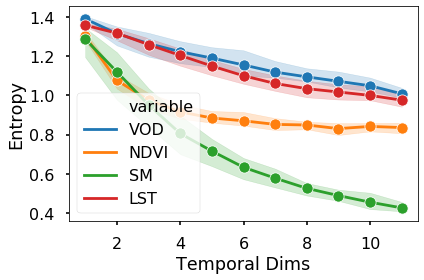

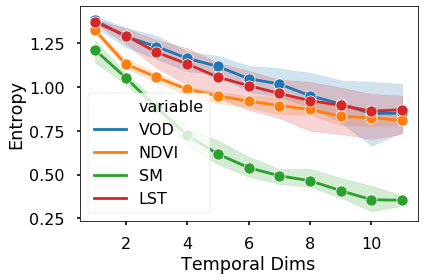

In [9]:
plot_entropy(data, normalized=True, save=False, drought=True)
plot_entropy(data, normalized=True, save=False, drought=False)

## Total Correlation

In [10]:
def plot_tc(data, normalized=False, save=True, drought=True):
    fig, ax = plt.subplots()
    
    if drought:
        drought = 'drought'
        data = data[data['year'].isin([2012, 2014, 2015])]
    
    elif not drought:
        drought = 'nondrought'
        data = data[data['year'].isin([2010, 2011, 2013])]
    else:
        raise ValueError('Unrecognized drought state: ', drought)
        
    if normalized:
        y = 'tc_norm'
        
    else:
        y = 'tc'
    sns.lineplot(
        x="temporal", y=y, 
        hue='variable', 
        data=data,
        marker='o', 
    )
    ax.set_xlabel('Temporal Dims')
    ax.set_ylabel('Total Correlation')
    # plt.legend(['NDVI', 'LST', 'SM', 'VOD'])
    plt.tight_layout()
    plt.show()
    if normalized and save:
        fig.savefig(f"{FIG_PATH}TC_norm_individual_{drought}.png", frameon=False, )
    elif save:
        fig.savefig(f"{FIG_PATH}TC_individual_{drought}.png", frameon=False, )
    

### Drought Years vs Non-Drought Years

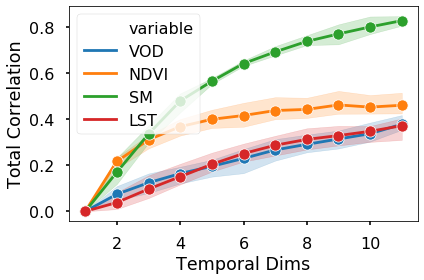

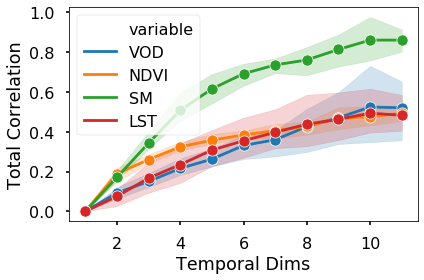

In [12]:
plot_tc(data, normalized=True, save=False, drought=True)
plot_tc(data, normalized=True, save=False, drought=False)

## Experiment II - Comparing Variables

In [13]:
data_group = pd.read_csv(DATA_PATH + datasets[1], index_col=[0])
data_group.head()

,drought,mi,pearson,samples,spearman,temporal,time,variable1,variable2,year
0,0.0,0.014735,0.064995,25779.0,0.083071,1.0,2.844188,VOD,NDVI,2010.0
1,0.0,0.024350,0.008711,25779.0,0.024544,1.0,2.887552,VOD,LST,2010.0
2,0.0,0.142746,0.150556,25779.0,0.290016,1.0,3.263144,VOD,SM,2010.0
3,0.0,0.019120,-0.107464,25779.0,-0.118719,1.0,2.836338,NDVI,LST,2010.0
4,0.0,0.059311,0.211504,25779.0,0.181002,1.0,2.830751,NDVI,SM,2010.0


### Normalize

In [14]:
# normalize
data_group['mi_norm'] = data_group['mi'].div(data_group.temporal)

In [15]:
cond1 = data_group['variable1'] == 'NDVI'
cond2 = data_group['variable2'] == 'NDVI'
data_group.loc[cond1 & cond2, ['variable1', 'variable2']] = data_group.loc[cond1 & cond2, ['variable2', 'variable1']].values

In [16]:
def move_variables(df: pd.DataFrame, variable: str)-> pd.DataFrame:
#     cond1 = df['variable1'] == variable
    cond = df['variable2'] == variable
    df.loc[
        cond, ['variable2', 'variable1']
    ] = df.loc[
        cond, ['variable1', 'variable2']
    ].values

    return df

In [17]:
df_new = move_variables(data_group, 'NDVI')

df_new.head()

,drought,mi,pearson,samples,spearman,temporal,time,variable1,variable2,year,mi_norm
0,0.0,0.014735,0.064995,25779.0,0.083071,1.0,2.844188,NDVI,VOD,2010.0,0.014735
1,0.0,0.024350,0.008711,25779.0,0.024544,1.0,2.887552,VOD,LST,2010.0,0.024350
2,0.0,0.142746,0.150556,25779.0,0.290016,1.0,3.263144,VOD,SM,2010.0,0.142746
3,0.0,0.019120,-0.107464,25779.0,-0.118719,1.0,2.836338,NDVI,LST,2010.0,0.019120
4,0.0,0.059311,0.211504,25779.0,0.181002,1.0,2.830751,NDVI,SM,2010.0,0.059311


### Mutual Information

In [18]:
def plot_mutual_info(data, normalized=False, save=True, variable='VOD', drought=True):
    fig, ax = plt.subplots()
    
    if drought:
        drought = 'drought'
        data = data[data['year'].isin([2012, 2014, 2015])]
    
    elif not drought:
        drought = 'nondrought'
        data = data[data['year'].isin([2010, 2011, 2013])]
    else:
        raise ValueError('Unrecognized drought state: ', drought)
        
    # Select variable
    data = move_variables(data, variable)
    
    data = data[data['variable1'] == variable]
#     print(data.variable2)
    if normalized:
        y = 'mi_norm'
        
    else:
        y = 'mi'
    sns.lineplot(
        x="temporal", y=y, 
        hue='variable2', 
        data=data,
        marker='o', 
    )
    ax.set_xlabel('Temporal Dims')
    ax.set_ylabel('Mutual Information')
    # plt.legend(['NDVI', 'LST', 'SM', 'VOD'])
    plt.tight_layout()
    plt.show()
    if normalized and save:
        fig.savefig(f"{FIG_PATH}MI_norm_individual_{drought}.png", frameon=False, )
    elif save:
        fig.savefig(f"{FIG_PATH}MI_individual_{drought}.png", frameon=False, )

In [22]:
def plot_pearson(data, normalized=False, save=True, variable='VOD', drought=True):
    fig, ax = plt.subplots()
    
    if drought:
        drought = 'drought'
        data = data[data['year'].isin([2012, 2014, 2015])]
    
    elif not drought:
        drought = 'nondrought'
        data = data[data['year'].isin([2010, 2011, 2013])]
    else:
        raise ValueError('Unrecognized drought state: ', drought)
        
    # Select variable
    data = move_variables(data, variable)
    
    data = data[data['variable1'] == variable]
#     print(data.variable2)
    if normalized:
        y = 'pearson'
        
    else:
        y = 'pearson'
    sns.lineplot(
        x="temporal", y=y, 
        hue='variable2', 
        data=data,
        marker='o', 
    )
    ax.set_xlabel('Temporal Dims')
    ax.set_ylabel('Pearson')
    # plt.legend(['NDVI', 'LST', 'SM', 'VOD'])
    plt.tight_layout()
    plt.show()
    if normalized and save:
        fig.savefig(f"{FIG_PATH}Pear_norm_individual_{drought}.png", frameon=False, )
    elif save:
        fig.savefig(f"{FIG_PATH}Pear_individual_{drought}.png", frameon=False, )

## VOD

### Drought Years

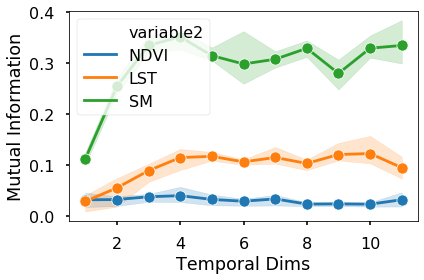

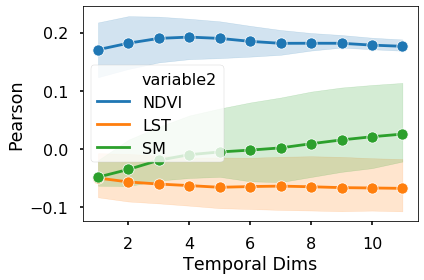

In [24]:
plot_mutual_info(data_group, normalized=True, save=True, variable='VOD', drought=True)
plot_pearson(data_group, normalized=False, save=True, variable='VOD', drought=True)


### Non-Drought Years

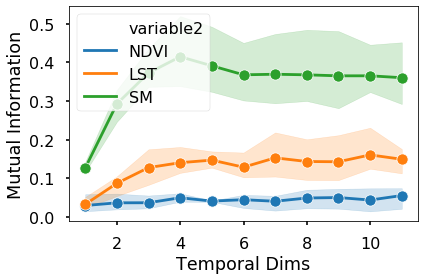

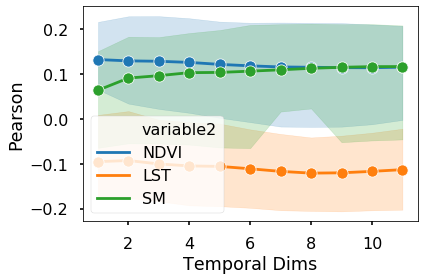

In [25]:
plot_mutual_info(data_group, normalized=True, save=True, variable='VOD', drought=False)
plot_pearson(data_group, normalized=False, save=True, variable='VOD', drought=False)

## NDVI

### Drought Years

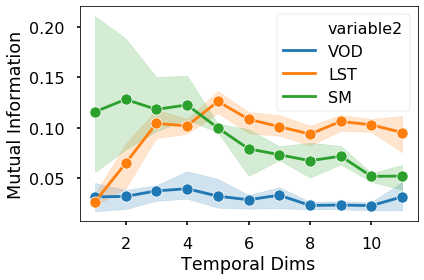

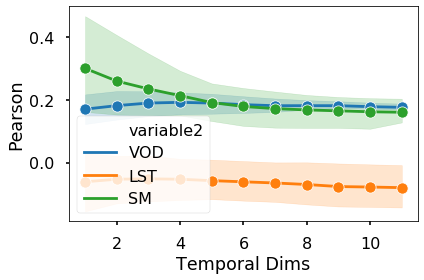

In [26]:
plot_mutual_info(data_group, normalized=True, save=True, variable='NDVI', drought=True)
plot_pearson(data_group, normalized=True, save=True, variable='NDVI', drought=True)

### Non-Drought Years

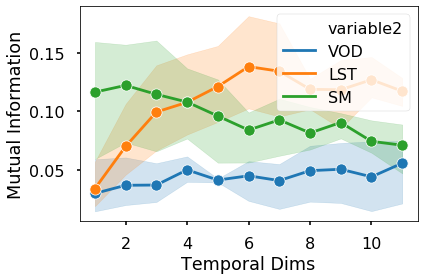

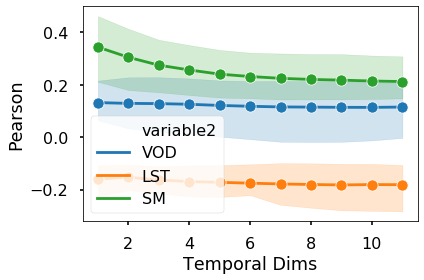

In [27]:
plot_mutual_info(data_group, normalized=True, save=True, variable='NDVI', drought=False)
plot_pearson(data_group, normalized=True, save=True, variable='NDVI', drought=False)

## LST

### Drought Years

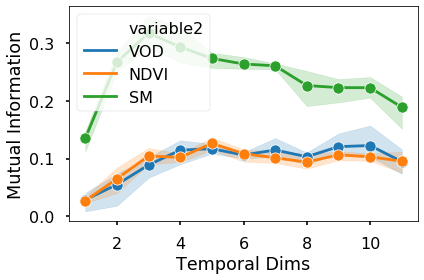

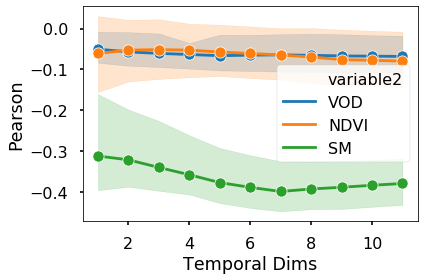

In [28]:
plot_mutual_info(data_group, normalized=True, save=True, variable='LST', drought=True)
plot_pearson(data_group, normalized=True, save=True, variable='LST', drought=True)

### Non-Drought Years

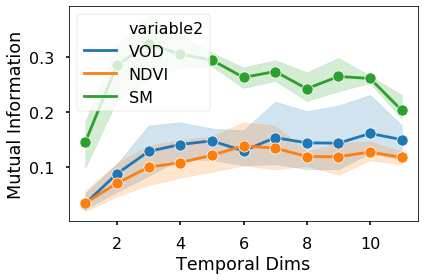

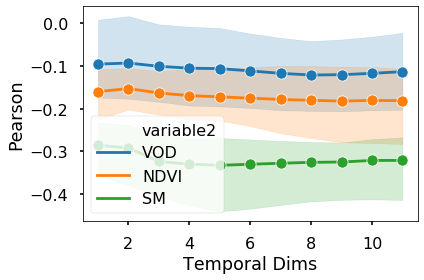

In [29]:
plot_mutual_info(data_group, normalized=True, save=True, variable='LST', drought=False)
plot_pearson(data_group, normalized=True, save=True, variable='LST', drought=False)

## SM

### Drought Years

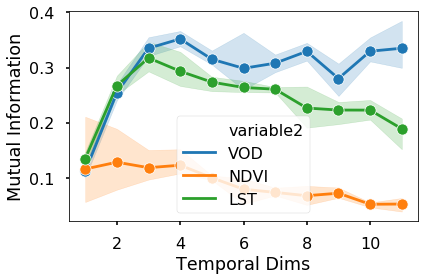

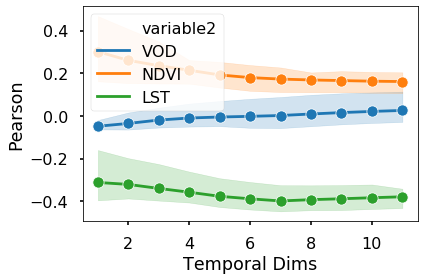

In [31]:
plot_mutual_info(data_group, normalized=True, save=True, variable='SM', drought=True)
plot_pearson(data_group, normalized=True, save=True, variable='SM', drought=True)

### Non-Drought Years

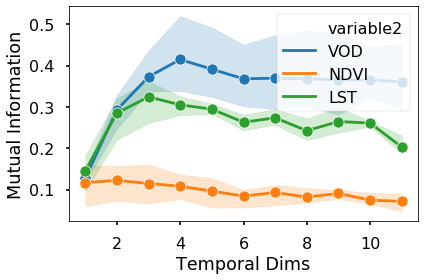

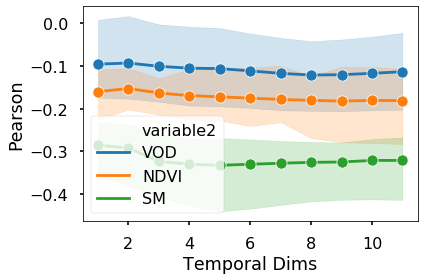

In [32]:
plot_mutual_info(data_group, normalized=True, save=True, variable='SM', drought=False)
plot_pearson(data_group, normalized=True, save=True, variable='LST', drought=False)